# Discovery association with noise
Goals:
- association between conformal scores of individual networks and ADOS and other behaviour
- computed by rank correlation
- repeated for the combinated ratings of these networks as well
- visualized

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import patsy as pat
import pathlib as pal
import seaborn as sbn
import statsmodels.api as sm
from scipy import stats as spss
from matplotlib import gridspec
from matplotlib import pyplot as plt

In [3]:
import pathlib as pal

# 📁 Base path = where this notebook lives
root_p = pal.Path().resolve()

# 📂 Input paths (Zenodo-style casing)
discovery_p = root_p / '../../output_data/Results/Discovery'
data_t = discovery_p / 'Results_Instance_{}_Network_{}.csv'
pheno_p = root_p / '../../source_data/Data/ABIDE_1_Pheno_PSM_matched_ados.tsv'
labels_p = root_p / '../../source_data/ATLAS/MIST/Parcel_Information/MIST_20_nocereb.csv'

# 📈 Output path (modern lowercase convention)
fig_p = root_p / '../../output_data/Figures/figure_3_nuisance'
fig_p.mkdir(parents=True, exist_ok=True)

In [4]:
def make_assoc_pearson(data, pheno, cov_name, boot_order):
    n_iter, n_sub, n_ensemble = data.shape
    array_out = np.zeros((n_iter, n_ensemble))

    for iteration in range(n_iter):
        for net in range(n_ensemble):
            boot_idx = boot_order[iteration, :].astype(int)
            mask = (~pheno.iloc[boot_idx][cov_name].isnull()).values.astype(bool)
            p1_prob = data[iteration, mask, net]
            p1_norm_prob = spss.norm.ppf(p1_prob)
            exog = pheno.iloc[boot_idx[mask]][cov_name].values
            r, p = spss.pearsonr(exog, p1_prob)
            array_out[iteration, net] = r

    return array_out

In [5]:
def make_tab(array):
    n_net = array.shape[1]
    tab = pd.DataFrame(data=array, columns=[f'net_{i+1}' for i in range(n_net)]).unstack().reset_index()
    tab.rename(columns={'level_0': 'network', 'level_1': 'iteration', 0: 'beta'}, inplace=True)
    return tab

In [6]:
pheno = pd.read_csv(pheno_p, sep='\t')
network_labels = pd.read_csv(labels_p, sep=';')

In [7]:
# Load and stack data
two = np.stack([
    pd.read_csv(discovery_p / f'split_net_{i+1}_p1.tsv', sep='\t').values.T
    for i in range(2)
], axis=-1)

results_array = np.stack([[pd.read_csv(str(data_t).format(instance+1, net+1)).values[:, 1:] 
                           for instance in range(100)] 
                          for net in range(18)], -1)

In [8]:
boot_order = results_array[:, :, 1, 0].astype(int) - 1 
individual = results_array[:, :, 2, :] 
n_sub = boot_order.shape[1]

## Age

In [9]:
age_individual = make_assoc_pearson(individual, pheno, 'AGE_AT_SCAN', boot_order)
age_ind_tab = make_tab(age_individual)
age_ind_tab['beta'].describe()

count    1800.000000
mean       -0.000313
std         0.113904
min        -0.403979
25%        -0.074687
50%         0.003718
75%         0.077101
max         0.400713
Name: beta, dtype: float64

In [10]:
age_two = make_assoc_pearson(two, pheno, 'AGE_AT_SCAN', boot_order)
age_two_tab = make_tab(age_two)
age_two_tab.groupby('network')['beta'].describe()

,count,mean,std,min,25%,50%,75%,max
network,,,,,,,,
net_1,100.0,-0.000839,0.156896,-0.413595,-0.092769,0.001299,0.132303,0.358115
net_2,100.0,-0.002658,0.130787,-0.315898,-0.094751,0.003290,0.084714,0.275583


## FD

In [11]:
fd_individual = make_assoc_pearson(individual, pheno, 'fd_scrubbed', boot_order)
fd_ind_tab = make_tab(fd_individual)
fd_ind_tab['beta'].describe()

count    1800.000000
mean       -0.007477
std         0.117158
min        -0.431972
25%        -0.079355
50%        -0.003652
75%         0.068431
max         0.466805
Name: beta, dtype: float64

In [12]:
fd_two = make_assoc_pearson(two, pheno, 'fd_scrubbed', boot_order)
fd_two_tab = make_tab(fd_two)
fd_two_tab.groupby('network')['beta'].describe()

,count,mean,std,min,25%,50%,75%,max
network,,,,,,,,
net_1,100.0,-0.015174,0.168381,-0.480128,-0.121019,-0.029194,0.106906,0.399708
net_2,100.0,-0.013174,0.136971,-0.437886,-0.095569,0.002377,0.065650,0.282635


## Make a figure

In [13]:
age_ind_tab.head()

,network,iteration,beta
0,net_1,0,0.014239
1,net_1,1,0.189650
2,net_1,2,0.189613
3,net_1,3,-0.061077
4,net_1,4,-0.160421


In [14]:
age_two_tab.head()

,network,iteration,beta
0,net_1,0,-0.039917
1,net_1,1,-0.091612
2,net_1,2,0.218783
3,net_1,3,0.138893
4,net_1,4,-0.060594


In [15]:
age_two_tab['type'] = 'Age'
fd_two_tab['type'] = 'Head Motion'
joint = pd.concat([fd_two_tab, age_two_tab])

In [16]:
def mm2in(mm):
    return mm/25.4

/tmp/ipykernel_371/656387512.py:76: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.savefig(fig_p / 'fig3_nuisance.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)


/tmp/ipykernel_371/656387512.py:77: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.savefig(fig_p / 'fig3_nuisance.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)


/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


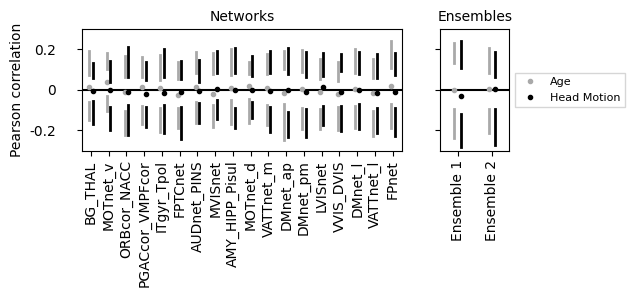

In [17]:
ci = 90
ci_step = (100-ci)/2
q_age_ind = np.stack([np.percentile(age_individual, quantile, axis=0) 
                          for quantile in [ci_step, 25, 50, 75, 100-ci_step]])
q_fd_ind = np.stack([np.percentile(fd_individual, quantile, axis=0) 
                          for quantile in [ci_step, 25, 50, 75, 100-ci_step]])
n_groups = q_age_ind.shape[1]
stack_x = np.tile(np.arange(n_groups), (2, 1))


q_age_ens = np.stack([np.percentile(age_two, quantile, axis=0) 
                          for quantile in [ci_step, 25, 50, 75, 100-ci_step]])
q_fd_ens = np.stack([np.percentile(fd_two, quantile, axis=0) 
                          for quantile in [ci_step, 25, 50, 75, 100-ci_step]])
n_groups_ens = q_age_ens.shape[1]
stack_x_ens = np.tile(np.arange(n_groups_ens), (2, 1))

dpi=300
scale_factor = 1
height = 40 * scale_factor
width = 140 * scale_factor

fig = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
gs = gridspec.GridSpec(nrows=1, ncols=24, hspace=0.2, figure=fig)
ax = fig.add_subplot(gs[:18])
ax_ens = fig.add_subplot(gs[20:])
ax.hlines(0, -.5, n_groups-0.5, zorder=0, color='black')
ax_ens.hlines(0, -.5, n_groups_ens-0.5, zorder=0, color='black')

# Plot ADOS CS
adjust = -0.1
for adjust, quantiles, color, label in zip([-0.1, 0.1], 
                                    [q_age_ind, q_fd_ind], 
                                    ['darkgrey', 'black'], 
                                    ['Age', 'Head Motion']):
    ax.plot(stack_x[0,:]+adjust, quantiles[2, :], color=color, marker='.', linestyle='', label=label)
    # Plot the lower CI
    ax.plot(stack_x+adjust, quantiles[0:2, :],color=color, linewidth=2)
    # Plot the upper CI
    ax.plot(stack_x+adjust, quantiles[3:, :], color=color, linewidth=2)

for adjust, quantiles, color, label in zip([-0.1, 0.1], 
                                    [q_age_ens, q_fd_ens], 
                                    ['darkgrey', 'black'], 
                                    ['Age', 'Head Motion']):
    ax_ens.plot(stack_x_ens[0,:]+adjust, quantiles[2, :], color=color, marker='.', linestyle='', label=label)
    # Plot the lower CI
    ax_ens.plot(stack_x_ens+adjust, quantiles[0:2, :],color=color, linewidth=2)
    # Plot the upper CI
    ax_ens.plot(stack_x_ens+adjust, quantiles[3:, :], color=color, linewidth=2)   
    
lgd = ax_ens.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=False, shadow=False, fontsize=8, title='');
ax.set_xticks(list(np.arange(n_groups)));
ax.set_xticklabels(network_labels['label'].values, rotation=90, fontsize=10);
ax.set_xlim([-0.5, n_groups-0.5])
ax.set_ylim([-0.3, 0.3])
ax.set_yticks([-0.2, 0, 0.2])
#ax.set_yticklabels(['negative association', 'no association', 'positive association']);
ax.set_yticklabels([-0.2, 0, 0.2]);
ax.set_ylabel('Pearson correlation', fontsize=10)
ax.set_title('Networks', fontsize=10)

ax_ens.set_xticks(list(np.arange(n_groups_ens)));
ax_ens.set_xticklabels(['Ensemble 1', 'Ensemble 2'], rotation=90, fontsize=10);
ax_ens.set_xlim([-0.5, n_groups_ens-0.5])
ax_ens.set_ylim([-0.3, 0.3])
ax_ens.set_yticks([-0.2, 0, 0.2])
#ax.set_yticklabels(['negative association', 'no association', 'positive association']);
ax_ens.set_yticklabels([]);
#ax.set_ylabel('Pearson correlation')
ax_ens.set_title('Ensembles', fontsize=10)

ax.tick_params(axis='y', which='major', pad=15)

fig.savefig(fig_p / 'fig3_nuisance.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
fig.savefig(fig_p / 'fig3_nuisance.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)